In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
os.makedirs('figs', exist_ok=True)

In [51]:
models = set(glob.glob('evals/*/*2.json') + glob.glob('evals/*/*/*2.json'))

In [52]:
data = [
    json.load(open(model, 'r', encoding='utf-8')) for model in models
]

In [53]:
def param_count(x: str):
    x = x.lower()
    pieces = x.split('-')
    for piece in pieces:
        if piece.endswith('b'):
            return round(float(piece.replace('b', '')) * 1000)
        elif piece.endswith('m'):
            return round(float(piece.replace('m', '')))

In [54]:
def mean_x(model, x):
    results = model['results']
    return sum([result[x] for result in results]) / len(results)

In [55]:
def mean_ratio(model, num, denom):
    results = model['results']
    nums = np.array([result[num] for result in results])
    denoms = np.array([result[denom] for result in results])
    return float((nums / denoms).mean())

In [56]:
data = sorted(data, key=lambda x: param_count(x['model_name']))
names = [datum['model_name'] for datum in data]
mean_latencies = [mean_x(datum, 'latency') for datum in data]
mean_peak = [mean_x(datum, 'peak_memory') for datum in data]
mean_response_len = [mean_x(datum, 'response_len') for datum in data]
size_on_disk = [datum['size_on_disk'] for datum in data]
cpu_mem_usage = [datum['cpu_mem_usage'] for datum in data]
gpu_mem_usage = [datum['gpu_mem_usage'] for datum in data]
local = ['local' if '/' in datum['model_name'] else 'remote' for datum in data]
params_count = [param_count(x) for x in names]
tps = [mean_ratio(x, 'response_len', 'latency') for x in data]

In [57]:
df = pd.DataFrame(
    {
        'Model name': names,
        'Mean latency (s)': mean_latencies,
        'Mean peak memory': mean_peak,
        'Mean response length (tokens)': mean_response_len,
        'Size on disk (GB)': size_on_disk,
        'CPU Usage (GB)': cpu_mem_usage,
        'GPU Usage (GB)': gpu_mem_usage,
        'Local': local,
        'Parameter count': params_count,
        'Tokens per second': tps
    }
)

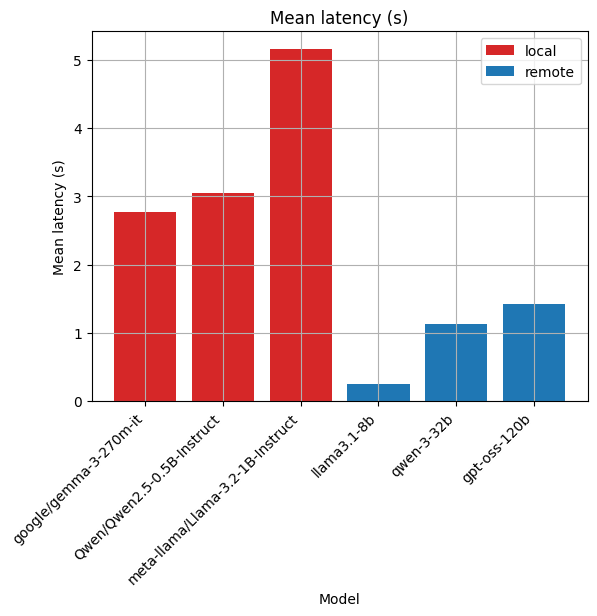

In [58]:
fig, ax = plt.subplots()
color = ['tab:red' if x=='local' else 'tab:blue' for x in local]
labels = ['_' + x for x in local]
labels[0] = labels[0].replace('_', '')
labels[-1] = labels[-1].replace('_', '')
ax.bar(df['Model name'], df['Mean latency (s)'], color=color, label=labels)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Mean latency (s)')
plt.legend()
plt.grid()
plt.title('Mean latency (s)')
plt.savefig('figs/latency_by_model.pdf', dpi=300, bbox_inches='tight')

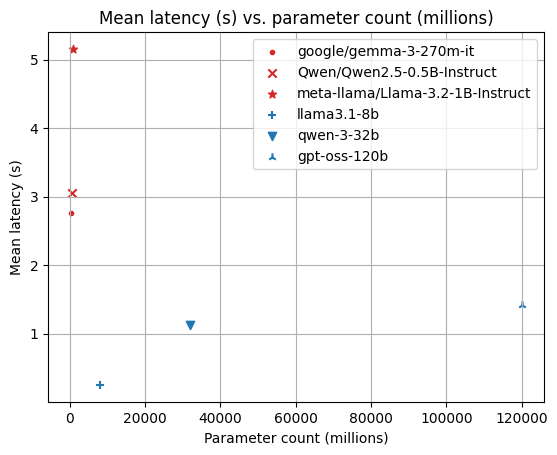

In [59]:
plt.figure()
markers = ['.', 'x', '*', '+', 'v', '2']
for i in range(6):
    plt.scatter(df['Parameter count'][i], df['Mean latency (s)'][i], c = color[i], marker=markers[i])
plt.xlabel('Parameter count (millions)')
plt.ylabel('Mean latency (s)')
plt.legend(labels=names)
plt.grid()
plt.title('Mean latency (s) vs. parameter count (millions)')
plt.savefig('figs/latency_vs_params.pdf', dpi=300, bbox_inches='tight')

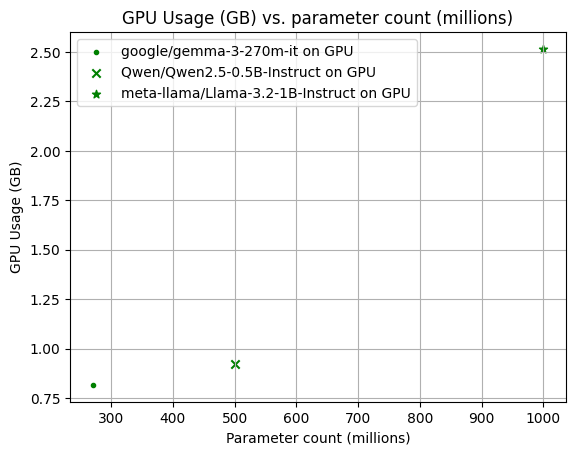

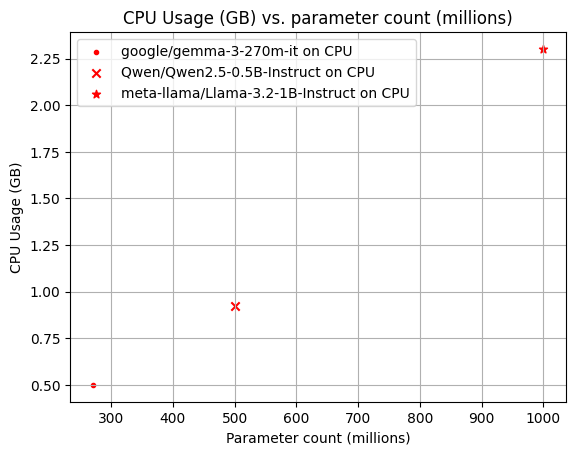

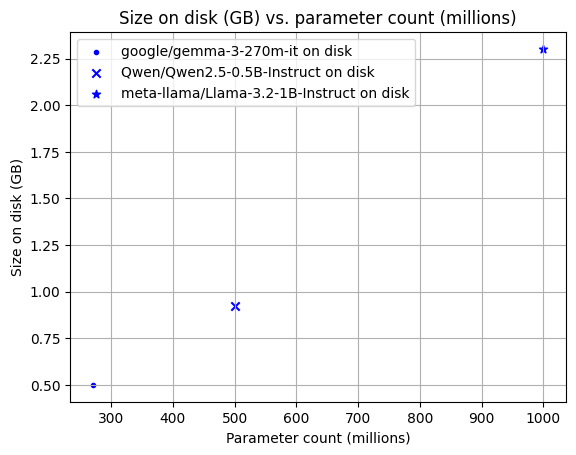

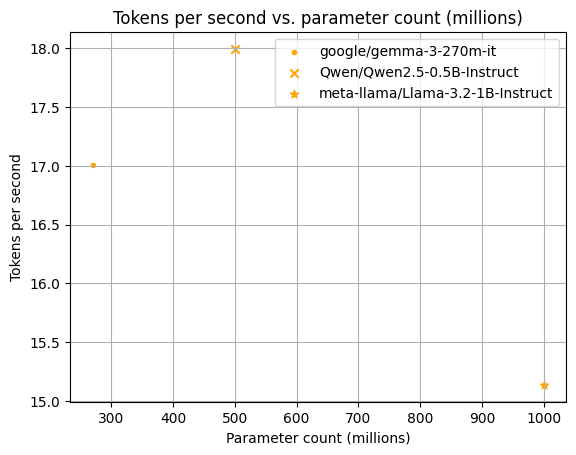

In [60]:
ylabs = ['GPU Usage (GB)','CPU Usage (GB)','Size on disk (GB)','Tokens per second']
legend_labs = [' on GPU',' on CPU',' on disk', '']
fname = ['gpu', 'cpu', 'disk', 'tps']
colors = ['green', 'red', 'blue', 'orange']

for j, ylab in enumerate(ylabs):
    plt.figure()
    markers = ['.', 'x', '*']
    labels = []
    for i in range(3):
        plt.scatter(df['Parameter count'][i], df[ylab][i], c = colors[j], marker=markers[i])
        labels.append(names[i] + legend_labs[j])
    plt.title(ylab + ' vs. parameter count (millions)')
    plt.xlabel('Parameter count (millions)')
    plt.ylabel(ylab)
    plt.legend(labels=labels)
    plt.grid()
    plt.savefig(f'figs/{fname[j]}_vs_params.pdf', dpi=300, bbox_inches='tight')

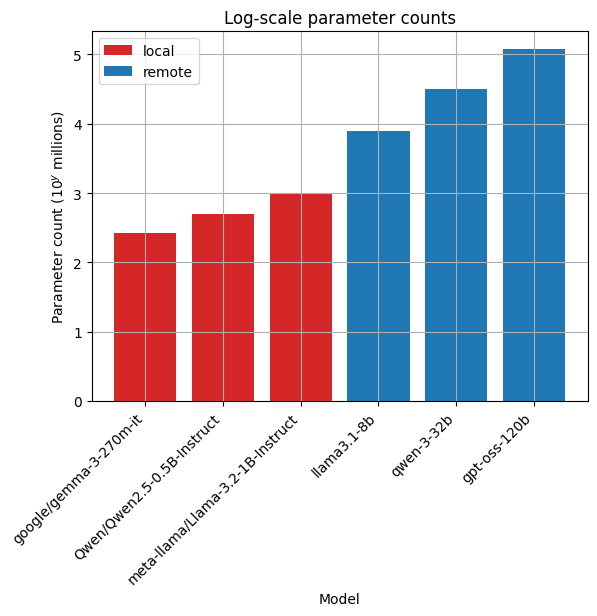

In [61]:
fig, ax = plt.subplots()
color = ['tab:red' if x=='local' else 'tab:blue' for x in local]
labels = ['_' + x for x in local]
labels[0] = labels[0].replace('_', '')
labels[-1] = labels[-1].replace('_', '')
ax.bar(df['Model name'], np.log10(df['Parameter count']), color=color, label=labels)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel(r'Parameter count ($10^y$ millions)')
plt.legend()
plt.title('Log-scale parameter counts')
plt.grid()
plt.savefig('figs/log_params.pdf', dpi=300, bbox_inches='tight')